# <font style="font-size:40px"><center><b>Machine Learning</b></center></font><font                        style="font-size:30px"><center><b>Master in Computational Finance (MCF) </b></center></font> 

<center> 

# 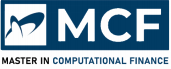

<center/>

# <font color='tomato' style="font-size:40px"><center><b>Feed-Forward Neural Networks</b></center></font></b></center></font> 

<center>
<b>profesor: </b> Nikola Vasiljevic

<b>students: </b> 
Nikola Krivacevic, Aleksandar Milinkovic
</center>





## Importing libraries:


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd  

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## (a) **Data preprocessing**: On top of the data preprocessing that was considered in the lectures, process your dataset further by standardizing the features. (2 pts)

Consider the California Housing Dataset that was studied and extensively discussed in the lectures.

The goal of this exercise is to implement a feed-forward neutral network (FFNN) for prediction of the target variable (i.e., the house prices in California). Please note that you do not have to use Keras to implement your FFNN models—you are free to choose any
package/library you like.

### California housing dataset EDA

We'll work on California housing dataset and will try to model the nonlinear relationship between the **house attributes** and the **house price**. By understanding the semantics of the features we have in dataset, we can conclude that the observations are not single houses, but median values for California districts/counties.

Our `target variable` is house price - `MedHouseVal`.

Dataset `features/regressors`:
- MedInc - median income for the district
- House age
- AveRooms - average num. of rooms in the house
- Population - number of people living in the district
- AveOccup - average number of tenants in the house
- Latitude/Logitude - geo location of county

#### Dataset statistical properties

In [3]:
# California housing dataset
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing()

In [4]:
# Create a dataframe containing observations
data = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
data['MedHouseVal'] = california_housing.target
data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [5]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


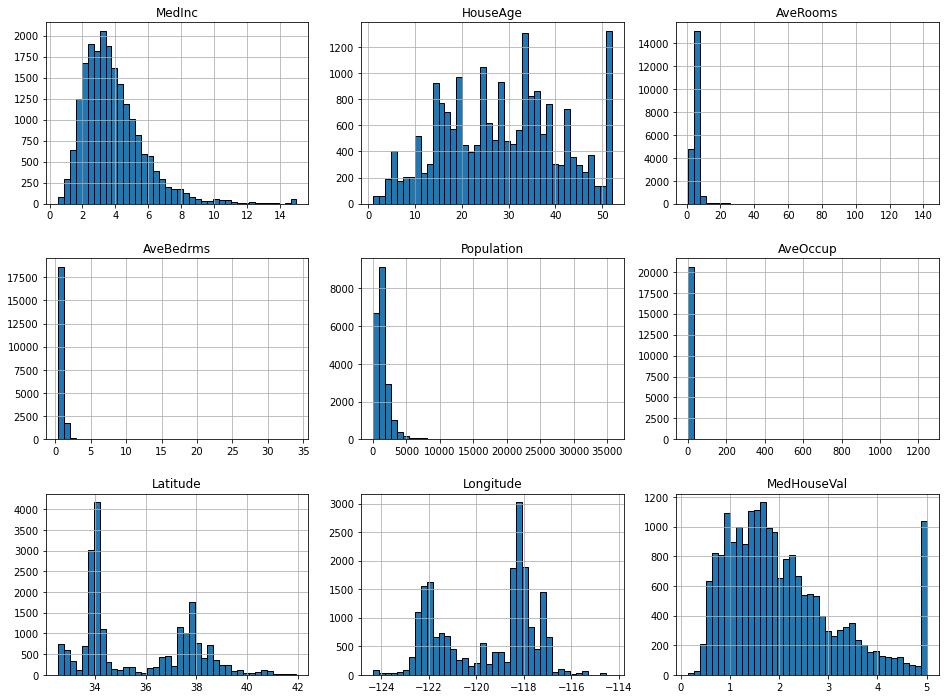

In [6]:
data.hist(figsize=(16, 12), bins=40, edgecolor='black')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

We can see that in our dataset observations we have some data that could potentially seen as outliers.

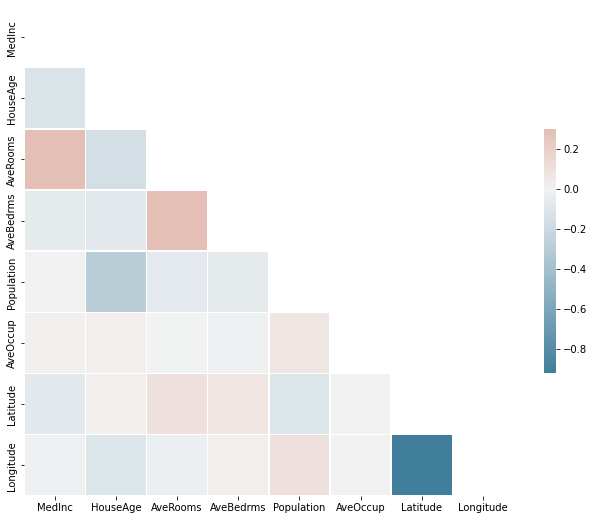

In [7]:
corr = data.drop(columns=["MedHouseVal"]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

From the correlation matrix above we can see that the **correalations between features are relatively low**, around zero.

Exception to that is the **latitude** and the **longitude** coordinates. They are highly negatively correlated (due to **geographic** shape of the state of California).

Intuition and reasoning for non-zero correlations in housing dataset:
- Low positive corelation between `AvgBedrooms` amd `MedInc` - that  makses sense as it is expected that individials and families who have a higher income would live in the bigger house
- `AvgBedrooms` and `AvgRooms`, although we don't know for sure how those feature are different (what they represent), we can see for that pair of features that they also have low, non-negative corerlation. 

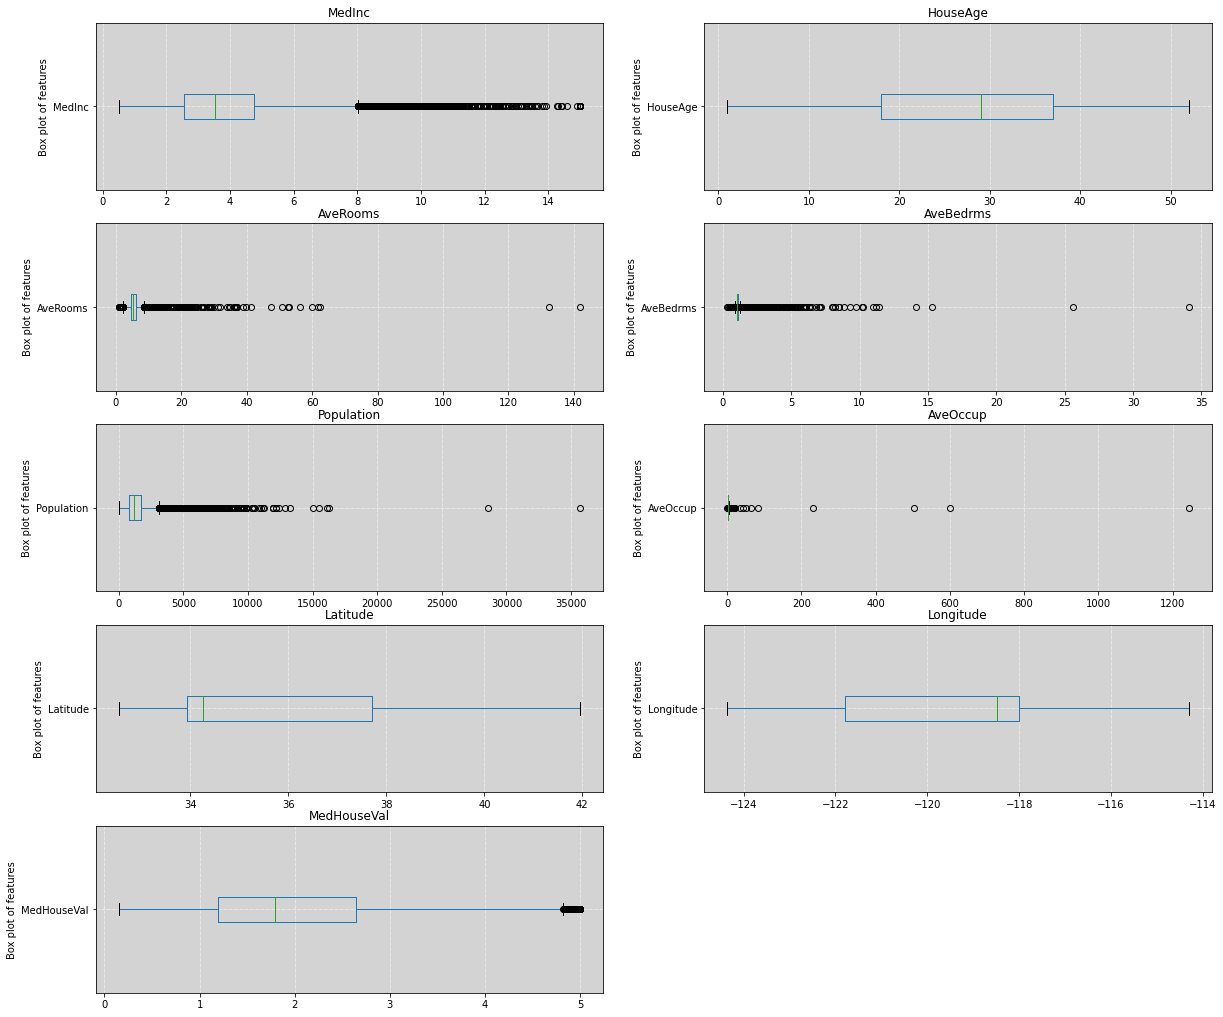

In [8]:
plt.figure(figsize=(20, 40))

for i, column in enumerate(data.columns):
    # Create subplots
    plt.subplot(11, 2, i + 1)
    data[column].plot.box(vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Box plot of features')
    plt.title(column)
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

From the Box plots of features, we can see that there could be some outliers (points outside of box plot "whiskers"; observations are considered outliers if their distance from the 25th/75th percentile if greater than 1.5 * IRQ).

#### Removing outliers

Now let's go feature by feature and try to remove the observations that seem to be outliers:

###### Average occupancy feature

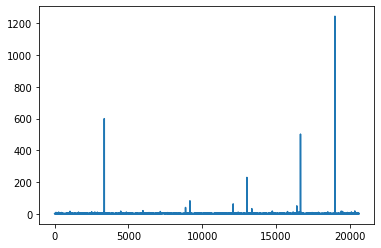

In [9]:
data['AveOccup'].plot()

In [10]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data[data['AveOccup'] > 8]
data_cleaned = data.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 53 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
91,0.8668,52.0,2.443182,0.988636,904.0,10.272727,37.80,-122.28,1.375
270,3.8750,33.0,3.021277,0.659574,575.0,12.234043,37.78,-122.18,2.250
460,1.4012,52.0,3.105714,1.060000,3337.0,9.534286,37.87,-122.26,1.750
1039,4.3029,16.0,6.090592,1.121951,4930.0,17.177700,38.42,-120.97,1.219
1067,3.4191,52.0,4.530612,0.816327,1107.0,11.295918,39.73,-121.85,1.375


###### Average rooms feature

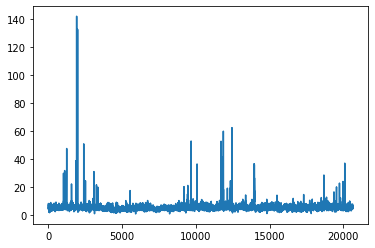

In [11]:
data['AveRooms'].plot()

In [12]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data_cleaned[data_cleaned['AveRooms'] > 10]
data_cleaned = data_cleaned.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 224 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
1023,2.2417,15.0,10.515306,2.372449,573.0,2.923469,38.72,-119.93,0.979
1024,3.1500,16.0,29.852941,5.323529,202.0,1.980392,38.52,-120.00,1.406
1030,3.0125,15.0,10.168591,2.057737,1103.0,2.547344,38.55,-120.25,1.117
1102,2.4028,17.0,31.777778,9.703704,47.0,1.740741,40.06,-121.54,0.675
1233,3.7500,10.0,16.847534,3.237668,546.0,2.448430,38.23,-120.34,1.214


###### Average bedrooms feature

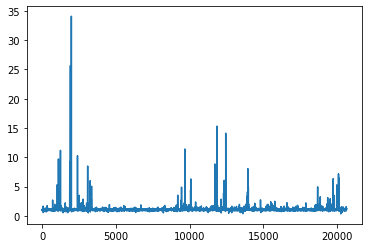

In [13]:
data['AveBedrms'].plot()

In [14]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data_cleaned[data_cleaned['AveBedrms'] > 2.5]
data_cleaned = data_cleaned.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 12 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
710,2.4196,26.0,8.518248,2.700730,253.0,1.846715,37.68,-122.08,2.750
1925,4.9583,10.0,5.062500,2.562500,55.0,3.437500,38.87,-120.50,0.875
2776,3.1607,18.0,9.314961,2.858268,374.0,2.944882,33.07,-114.98,0.575
3334,4.1250,30.0,5.384615,2.923077,20.0,1.538462,38.92,-122.65,1.125
12307,2.9141,11.0,9.855372,2.731405,682.0,2.818182,33.62,-116.74,2.143


###### Population feature

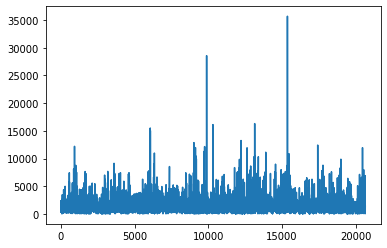

In [15]:
data['Population'].plot()

In [16]:
# Selecting which observations to remove based on the criteria
observations_to_remove = data_cleaned[data['Population'] > 15000]
data_cleaned = data_cleaned.drop(observations_to_remove.index)
print(f'Removing {len(observations_to_remove)} observations.')
observations_to_remove.head()

Removing 6 observations.


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
6057,6.0191,8.0,6.347327,1.047525,15507.0,3.070693,34.03,-117.78,2.539
6066,6.6288,7.0,6.802554,1.026277,15037.0,3.692780,34.04,-117.87,3.397
9880,2.3087,11.0,5.364518,1.059684,28566.0,4.696810,36.64,-121.79,1.188
10309,7.4947,4.0,7.311043,1.054346,16122.0,3.106957,33.89,-117.74,3.663
13139,4.9516,3.0,7.338559,1.159015,16305.0,3.043113,38.43,-121.44,1.537


#### Overview of the cleaned dataset

In [17]:
# Original dataset
data.shape

(20640, 9)

In [18]:
# Cleaned dataset
data_cleaned.shape

(20345, 9)

In [19]:
# Number of removed observations
print(f'{round(100 * (data.shape[0] - data_cleaned.shape[0]) / data.shape[0], 2)} % of data has been removed as outliers.')
print(f'{data.shape[0] - data_cleaned.shape[0]} observations have been removed as outliers.')

1.43 % of data has been removed as outliers.
295 observations have been removed as outliers.


Let's look now Box plots once again, to see how the feature value distribution has changed after removing values:

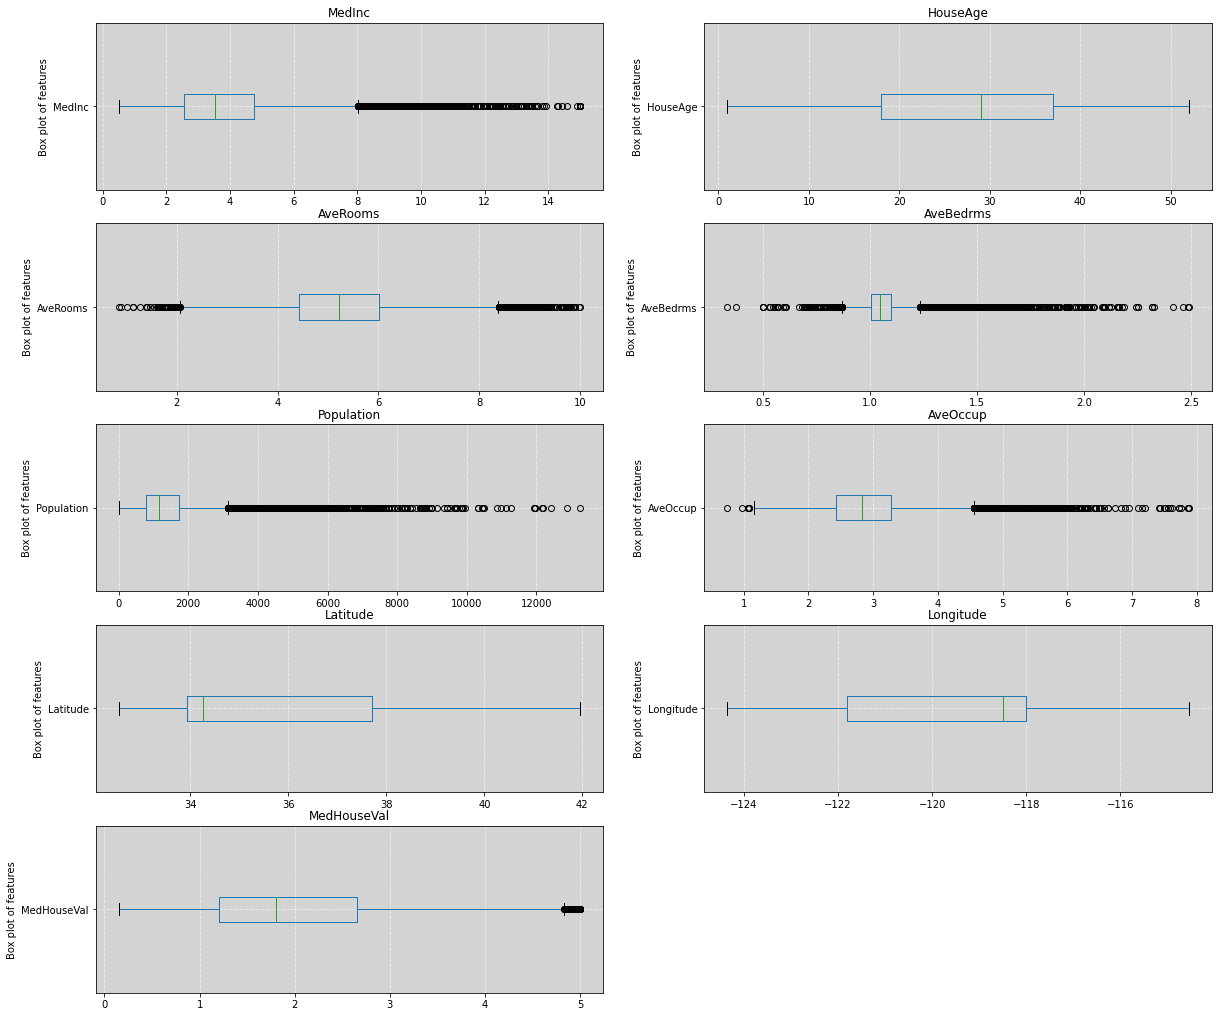

In [20]:
plt.figure(figsize=(20, 40))

for i, column in enumerate(data_cleaned.columns):
    # Create subplots
    plt.subplot(11, 2, i + 1)
    data_cleaned[column].plot.box(vert=False)
    # Labels and graphics
    plt.xlabel(None)
    plt.ylabel('Box plot of features')
    plt.title(column)
    plt.grid(color='white', linestyle='-.', linewidth=0.5)
    ax = plt.gca()
    ax.set_facecolor('lightgrey')

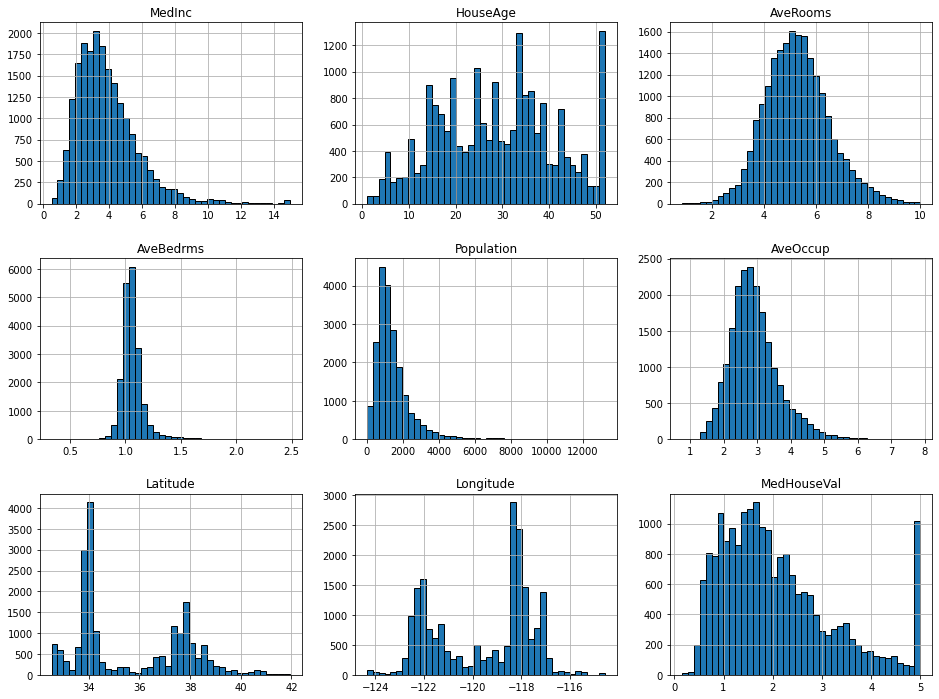

In [21]:
data_cleaned.hist(figsize=(16, 12), bins=40, edgecolor='black')
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

#### Standardizing cleaned dataset

Our dataset contains just over **20,000 observations** and **9 features**. The number of observations is much larger than the number of features, so we don't expect dimensionality problems nor multicolinearity problem amoung features in dataset as we previously seen that the corrlerations are relatively low.

In [22]:
data_cleaned.shape

(20345, 9)

In [23]:
data_cleaned.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

Before we move on, we'll standardize the features and target variable:

In [24]:
# Scale features
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data_cleaned)
X = scaled_data[:,0:-1]
y = scaled_data[:,-1].reshape(1,-1)

X.shape, y.shape

((20345, 8), (1, 20345))

#### Splitting the dataset into training and testing set

Let's now also split our dataset into the:
- Training set (80% of the observations ~ 16,276 observations)
- Testing set (20% of the observations ~ 4,069 observations)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y[0,:], test_size=0.2, random_state=42)

print(f'Features: trn={len(X_train)} test={len(X_test)}')
print(f'Target: train={len(y_train)} test={len(y_test)}')

Features: trn=16276 test=4069
Target: train=16276 test=4069


## (b) Implementation: Implement an arbitrary two or three-layer FFNN model and compare its in-sample and out-of-sample performance with the supervised learning models considered in the Machine Learning Homework 2. (5 pts)

Now when the dataset is ready and prepared for modeling we're going to try to fit FFNN models. We're are going to try with a couple of different neural network achitectures:
- 2 layer model:
  - 1st hidden layer: 8 neurons
  - 2nd hidden layer: 8 neurons
- 2 layer model:
  - 1st hidden layer: 32 neurons
  - 2nd hidden layer: 16 neurons
- 3 layer model:
  - 1st hidden layer: 8 neurons
  - 2nd hidden layer: 8 neurons
  - 3rd hidden layer: 4 neurons

- [Keras/Tensor Flow regression metrics](https://keras.io/api/metrics/regression_metrics/)
- [Keras/Tensor Flow regression loss functions](https://keras.io/api/losses/regression_losses/)

`Note`: Please note that model training can take a while.

Similar as in the previous modeling of this dataset, with regression models, for evaluation metric we're goint to use RMSE.

### Baseline model (2-layer model, 8x8)

We will take this 2-layer model as the baseline model.

In [26]:
# Architecting the model
baseline_model = Sequential(name='baseline_model') 

# Hidden layers
baseline_model.add(Dense(8, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
baseline_model.add(Dense(8, activation='relu', kernel_initializer='he_uniform', name='Hidden_Layer_2'))

# Output layer (no activation; liner activation function for regression)
baseline_model.add(Dense(1, activation='linear', name='Output_Layer'))

In [27]:
# Compiling the model
baseline_model.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

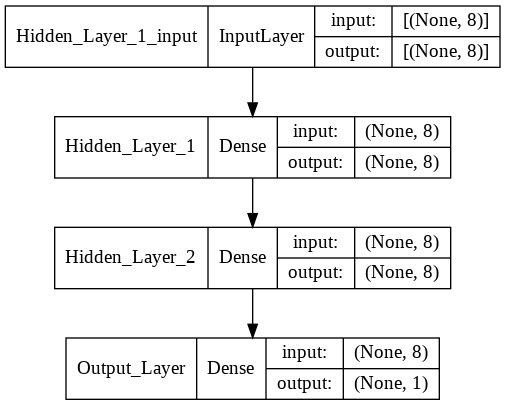

In [28]:
# Visualizing the model
keras.utils.plot_model(baseline_model, show_shapes=True)

In [29]:
# Training the model
n_epochs     = 500
n_batch_size = 1024 

baseline_model_fitted = baseline_model.fit(
    X_train, 
    y_train, 
    epochs=n_epochs, 
    batch_size=n_batch_size, 
    validation_data=(X_test, y_test)
)

Epoch 1/500
16/16 [==============================] - 2s 36ms/step - loss: 1.6202 - mean_squared_error: 1.6202 - val_loss: 1.5097 - val_mean_squared_error: 1.5097
Epoch 2/500
16/16 [==============================] - 0s 10ms/step - loss: 1.3499 - mean_squared_error: 1.3499 - val_loss: 1.2768 - val_mean_squared_error: 1.2768
Epoch 3/500
16/16 [==============================] - 0s 8ms/step - loss: 1.1479 - mean_squared_error: 1.1479 - val_loss: 1.1034 - val_mean_squared_error: 1.1034
Epoch 4/500
16/16 [==============================] - 0s 13ms/step - loss: 0.9940 - mean_squared_error: 0.9940 - val_loss: 0.9666 - val_mean_squared_error: 0.9666
Epoch 5/500
16/16 [==============================] - 0s 13ms/step - loss: 0.8702 - mean_squared_error: 0.8702 - val_loss: 0.8575 - val_mean_squared_error: 0.8575
Epoch 6/500
16/16 [==============================] - 0s 6ms/step - loss: 0.7724 - mean_squared_error: 0.7724 - val_loss: 0.7670 - val_mean_squared_error: 0.7670
Epoch 7/500
16/16 [===========

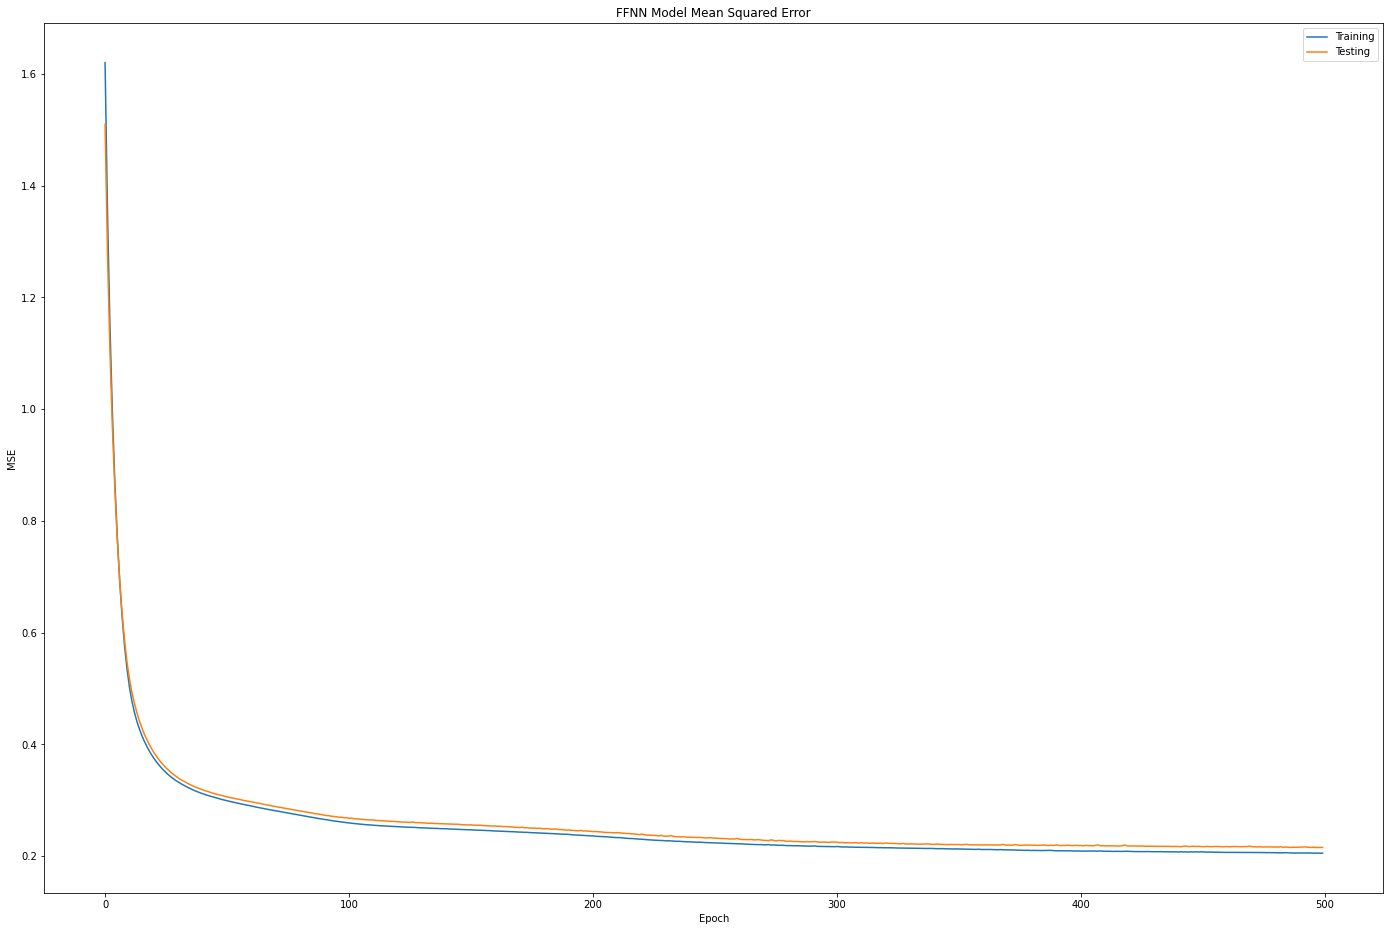

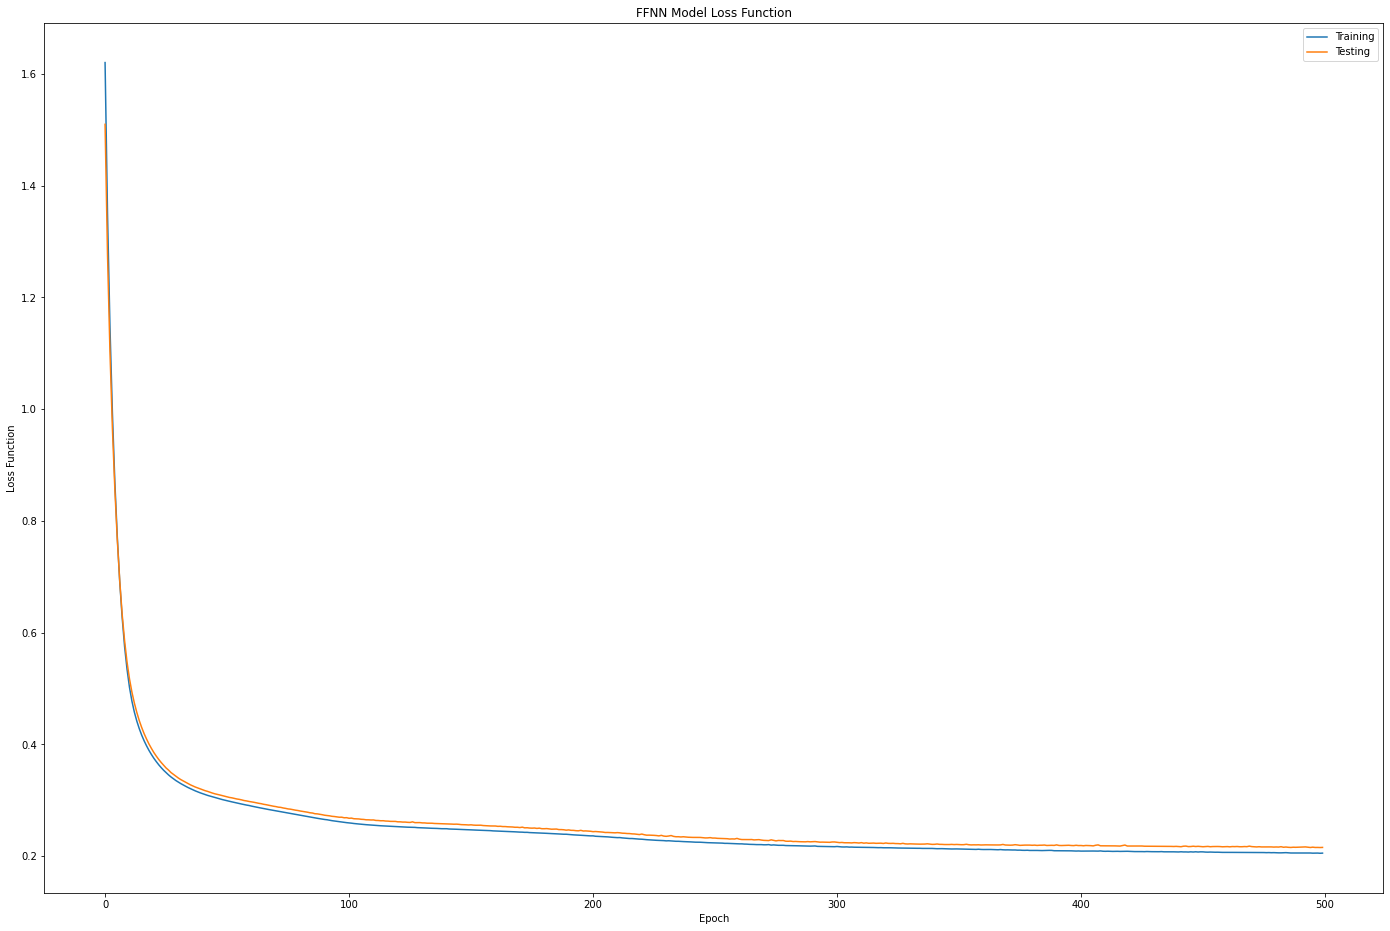

In [30]:
# Plot history for MSE
plt.figure(figsize=(24,16))
plt.plot(baseline_model_fitted.history['mean_squared_error'])
plt.plot(baseline_model_fitted.history['val_mean_squared_error'])
plt.title('FFNN Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

# Plot history for loss function
plt.figure(figsize=(24,16))
plt.plot(baseline_model_fitted.history['loss'])
plt.plot(baseline_model_fitted.history['val_loss'])
plt.title('FFNN Model Loss Function')
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

In [31]:
# Predicting the house prices

# Trainig set: in-sample prediction
y_pred_train = baseline_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
r_squared = r2_score(y_train, y_pred_train)

# Testing seg: out-of-sample prediction
y_pred_test = baseline_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

In [32]:
# Saving model performance results
model_comparison = pd.DataFrame([], columns=['Model', 'R-squared (in-sample)', 'RMSE (in-sample)', 'RMSE (out-of-sample)'])
model_comparison.loc[0] = ['FFNN (2h, 8x8)', r_squared, train_rmse, test_rmse]

### Wider Network Topology (2-layer model, 32x16)

Improvement from the base model is that we're making a wider neural network. It has the same number of hidden layers, but those layers contain a larger number of neurons.

In [33]:
# Architecting the model
wider_model = Sequential(name='wider_model') 

# Hidden layers
wider_model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
wider_model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Hidden_Layer_2'))

# Output layer (no activation; liner activation function for regression)
wider_model.add(Dense(1, activation='linear', name='Output_Layer'))

In [34]:
# Compiling the model
wider_model.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

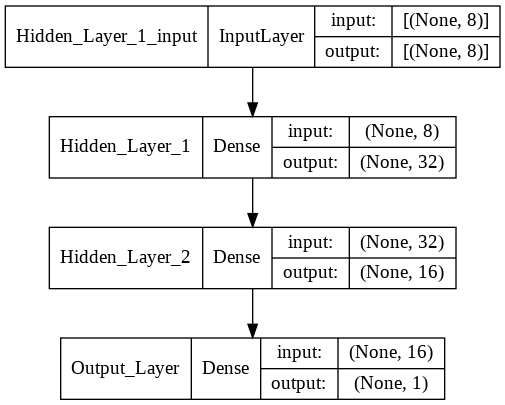

In [35]:
# Visualizing the model
keras.utils.plot_model(wider_model, show_shapes=True)

In [36]:
# Training the model
n_epochs     = 500
n_batch_size = 1024 

wider_model_fitted = wider_model.fit(
    X_train, 
    y_train, 
    epochs=n_epochs, 
    batch_size=n_batch_size, 
    validation_data=(X_test, y_test)
)

Epoch 1/500
16/16 [==============================] - 1s 16ms/step - loss: 1.8135 - mean_squared_error: 1.8135 - val_loss: 1.3383 - val_mean_squared_error: 1.3383
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 1.0644 - mean_squared_error: 1.0644 - val_loss: 0.8866 - val_mean_squared_error: 0.8866
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.7406 - mean_squared_error: 0.7406 - val_loss: 0.6973 - val_mean_squared_error: 0.6973
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 0.6068 - mean_squared_error: 0.6068 - val_loss: 0.6097 - val_mean_squared_error: 0.6097
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 0.5407 - mean_squared_error: 0.5407 - val_loss: 0.5561 - val_mean_squared_error: 0.5561
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 0.4976 - mean_squared_error: 0.4976 - val_loss: 0.5168 - val_mean_squared_error: 0.5168
Epoch 7/500
16/16 [==============

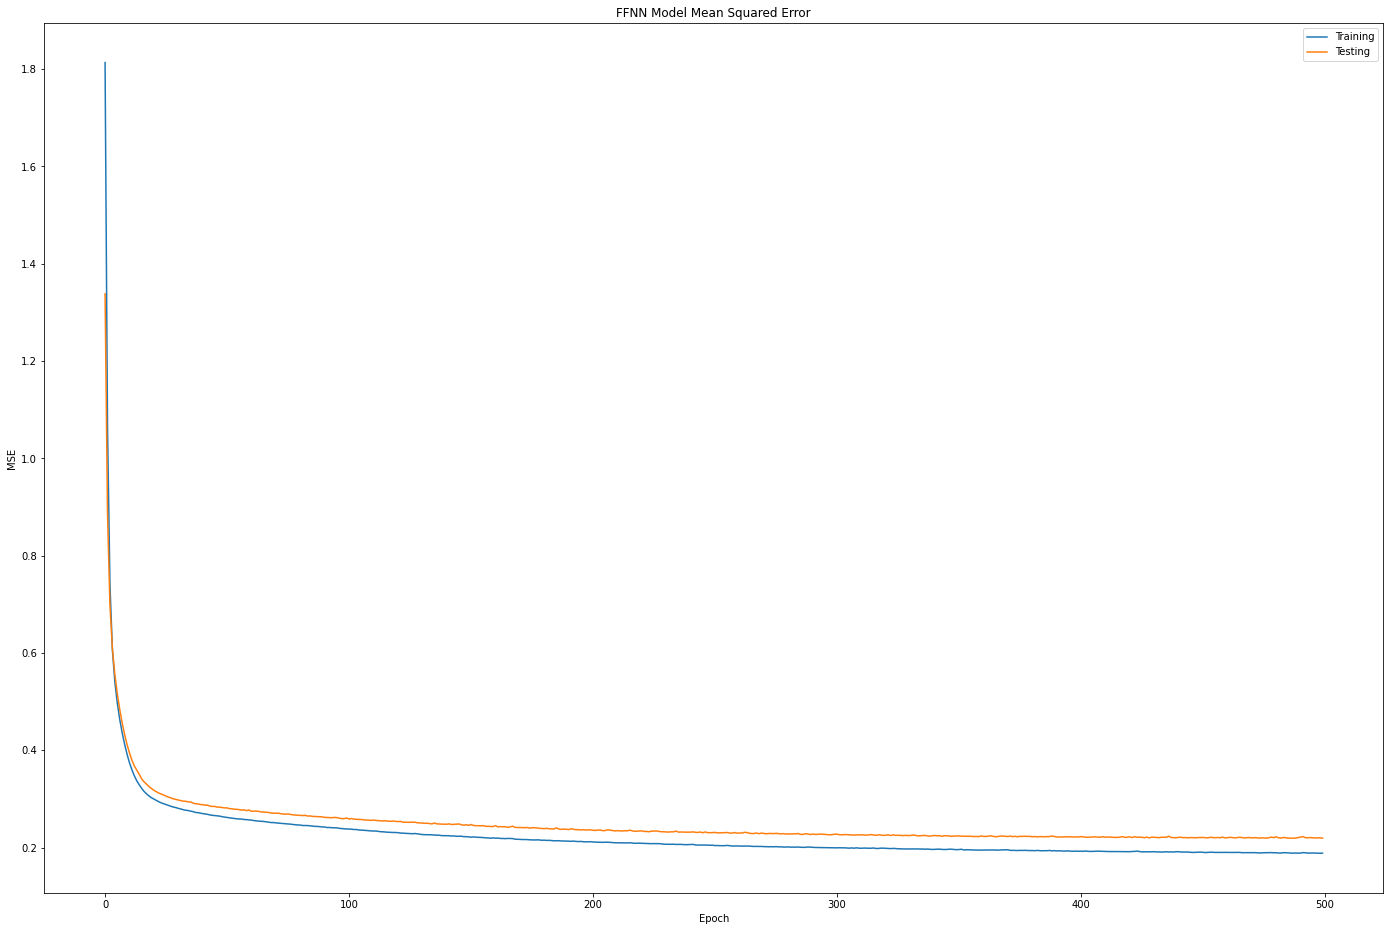

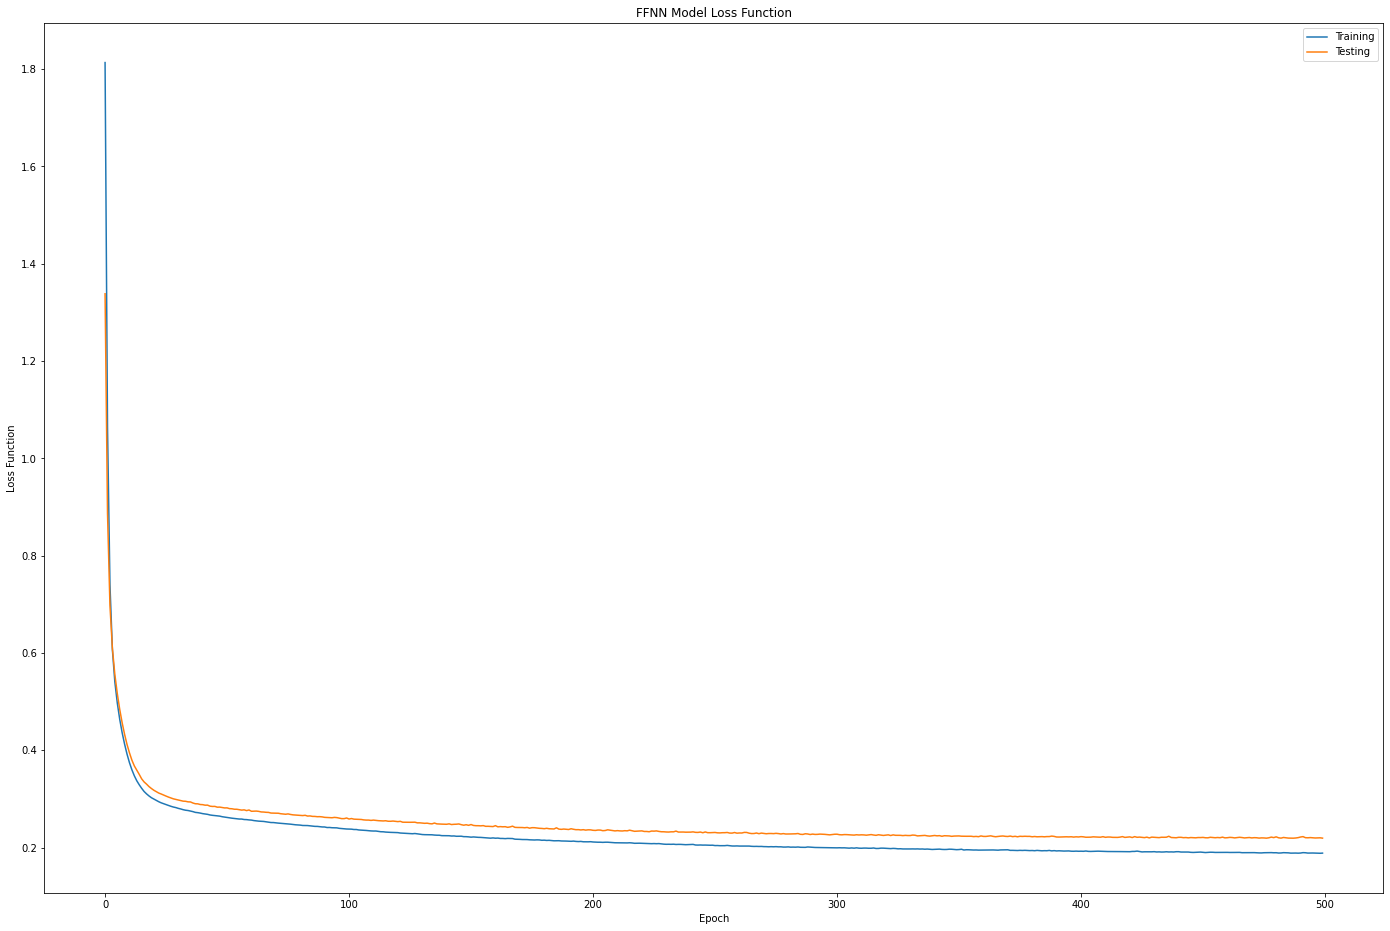

In [37]:
# Plot history for MSE
plt.figure(figsize=(24,16))
plt.plot(wider_model_fitted.history['mean_squared_error'])
plt.plot(wider_model_fitted.history['val_mean_squared_error'])
plt.title('FFNN Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

# Plot history for loss function
plt.figure(figsize=(24,16))
plt.plot(wider_model_fitted.history['loss'])
plt.plot(wider_model_fitted.history['val_loss'])
plt.title('FFNN Model Loss Function')
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

In [38]:
# Predicting the house prices

# Trainig set: in-sample prediction
y_pred_train = wider_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
r_squared = r2_score(y_train, y_pred_train)

# Testing seg: out-of-sample prediction
y_pred_test = wider_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

In [39]:
# Saving model performance results
model_comparison.loc[1] = ['FFNN (2h, 32x16)', r_squared, train_rmse, test_rmse]

### Deeper topology (3-layer model, 8x8x4)

And additional deviation from the baseline model is this model. It follows the same number of nuerons but adds an additional hidden layer, making the network a bit deeper.

In [40]:
# Architecting the model
deeper_model = Sequential(name='deeper_model') 

# Hidden layers
deeper_model.add(Dense(8, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
deeper_model.add(Dense(8, activation='relu', kernel_initializer='he_uniform', name='Hidden_Layer_2'))
deeper_model.add(Dense(4, activation='relu', kernel_initializer='he_uniform', name='Hidden_Layer_3'))

# Output layer (no activation; liner activation function for regression)
deeper_model.add(Dense(1, activation='linear', name='Output_Layer'))

In [41]:
# Compiling the model
deeper_model.compile(
    optimizer='adam', 
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

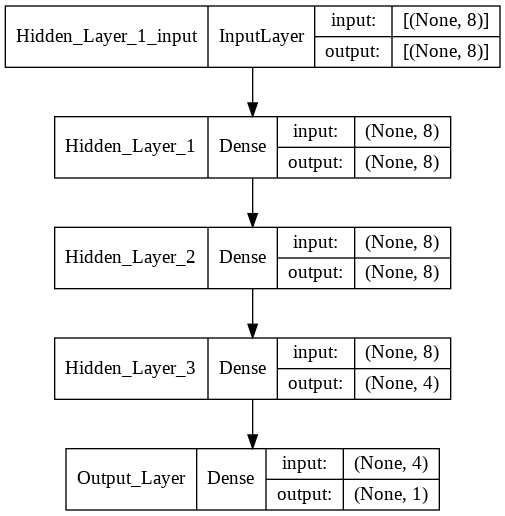

In [42]:
# Visualizing the model
keras.utils.plot_model(deeper_model, show_shapes=True)

In [43]:
# Training the model
n_epochs     = 500
n_batch_size = 1024 

deeper_model_fitted = deeper_model.fit(
    X_train, 
    y_train, 
    epochs=n_epochs, 
    batch_size=n_batch_size, 
    validation_data=(X_test, y_test)
)

Epoch 1/500
16/16 [==============================] - 1s 33ms/step - loss: 3.6675 - mean_squared_error: 3.6675 - val_loss: 2.7944 - val_mean_squared_error: 2.7944
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 2.5028 - mean_squared_error: 2.5028 - val_loss: 1.9795 - val_mean_squared_error: 1.9795
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 1.8364 - mean_squared_error: 1.8364 - val_loss: 1.5279 - val_mean_squared_error: 1.5279
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 1.4655 - mean_squared_error: 1.4655 - val_loss: 1.2977 - val_mean_squared_error: 1.2977
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 1.2673 - mean_squared_error: 1.2673 - val_loss: 1.1733 - val_mean_squared_error: 1.1733
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 1.1559 - mean_squared_error: 1.1559 - val_loss: 1.1067 - val_mean_squared_error: 1.1067
Epoch 7/500
16/16 [==============

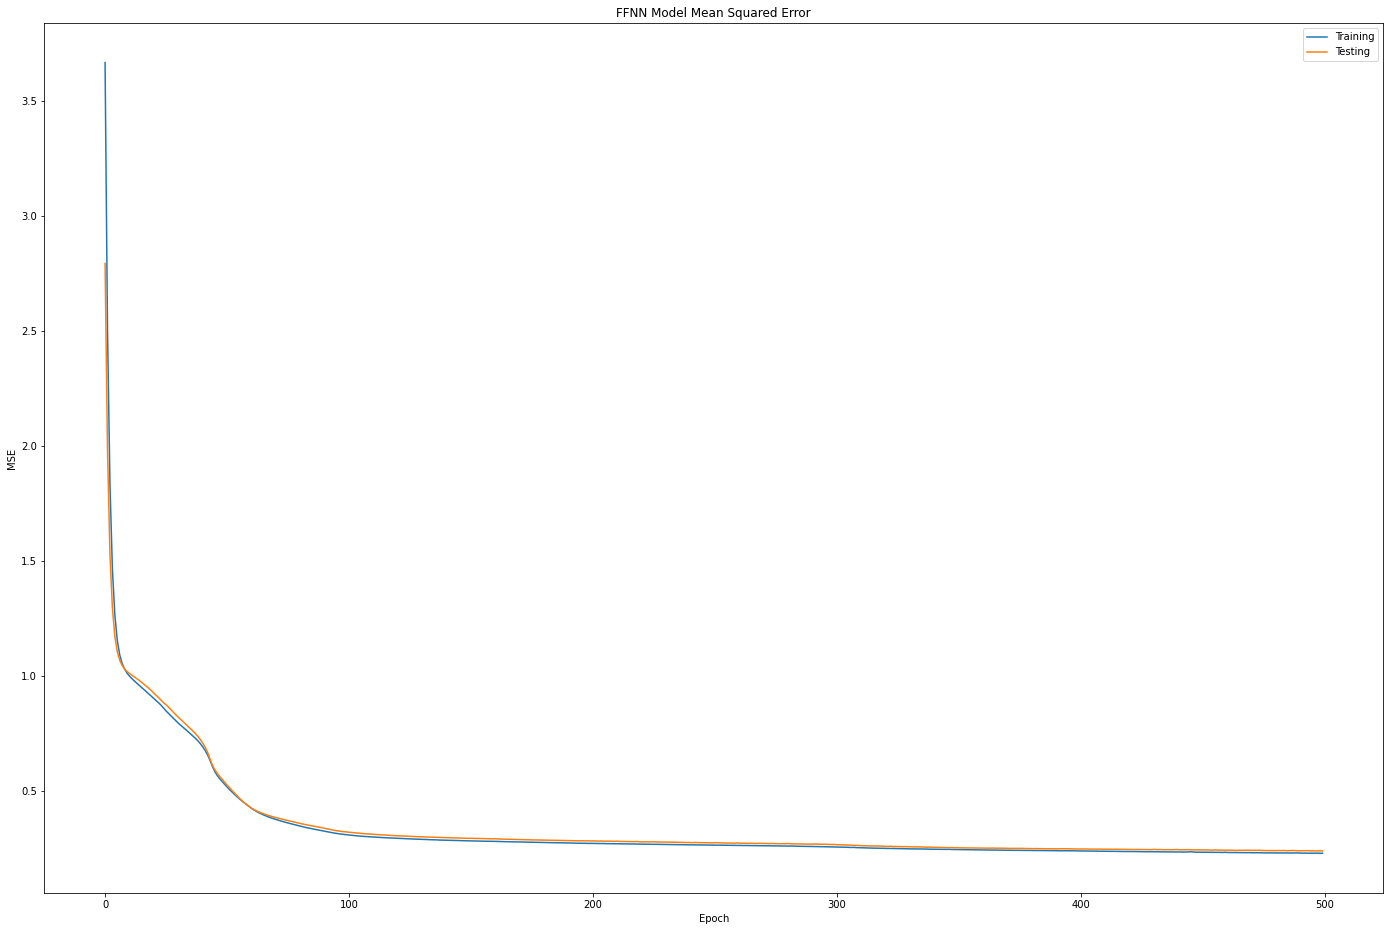

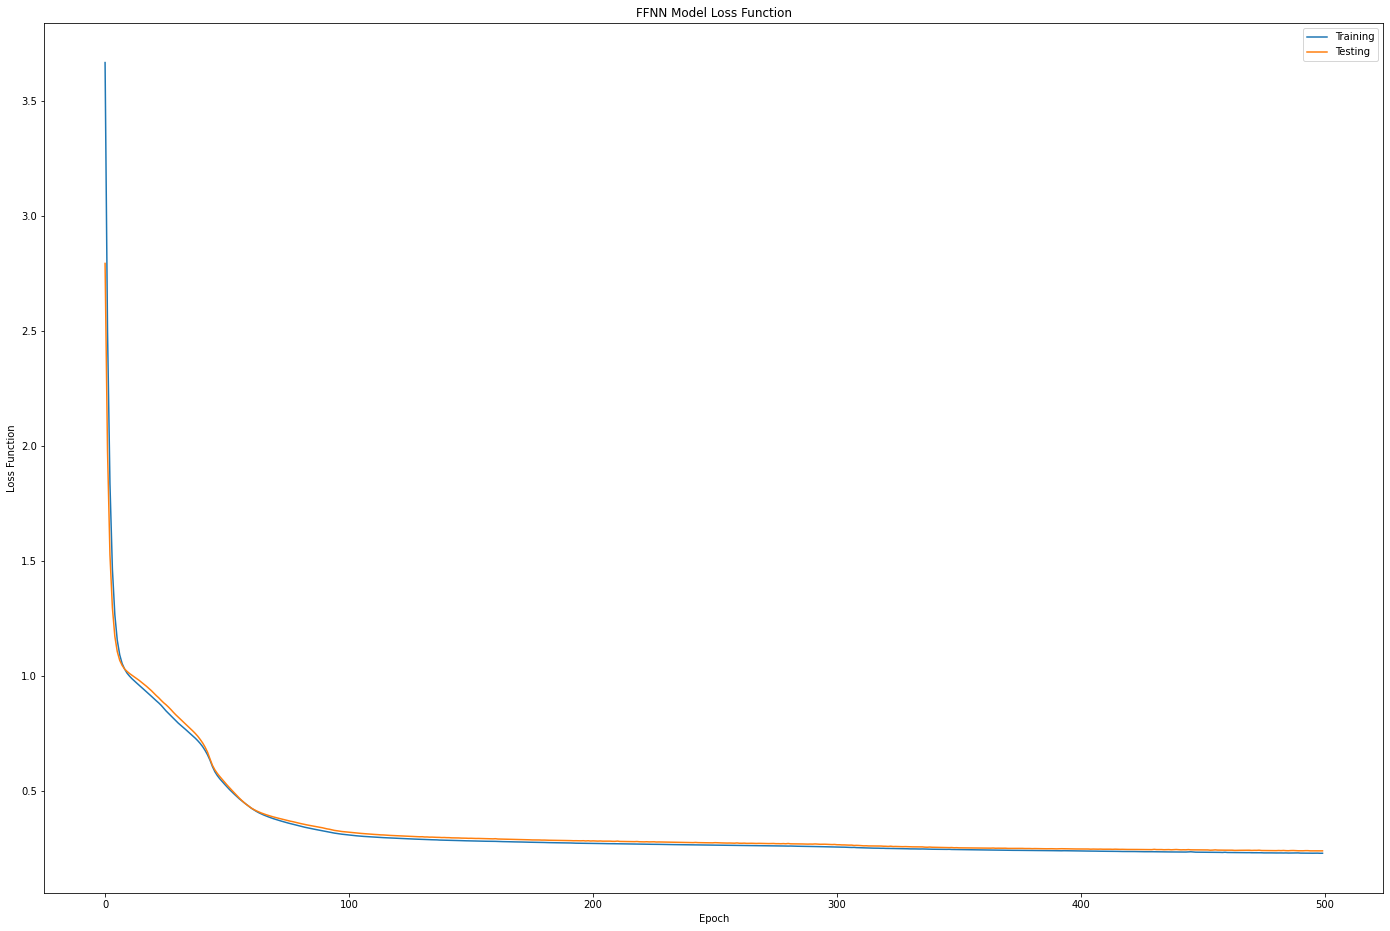

In [44]:
# Plot history for MSE
plt.figure(figsize=(24,16))
plt.plot(deeper_model_fitted.history['mean_squared_error'])
plt.plot(deeper_model_fitted.history['val_mean_squared_error'])
plt.title('FFNN Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

# Plot history for loss function
plt.figure(figsize=(24,16))
plt.plot(deeper_model_fitted.history['loss'])
plt.plot(deeper_model_fitted.history['val_loss'])
plt.title('FFNN Model Loss Function')
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

In [45]:
# Predicting the house prices

# Trainig set: in-sample prediction
y_pred_train = deeper_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
r_squared = r2_score(y_train, y_pred_train)

# Testing seg: out-of-sample prediction
y_pred_test = deeper_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

In [46]:
# Saving model performance results
model_comparison.loc[2] = ['FFNN (3h, 8x8x4)', r_squared, train_rmse, test_rmse]

### Model comparison

`Note`: As for the neural network model training gradient descent is used, rerunning the notebook may result in different numbers.

#### FFNN models

We designed, fitted and evaluated 3 different neural networks for predicting the house prices.

Now let's compare those three models and see which one performed the best.

Based on both the in-sample and out-of-sample evaluation, we can see that the neural network that has `2 hidden layers (first with 32 and second with 16 neurons)` performed the best.

`Note`: Models were trained a couple of times and in each run the second model (`FFNN (2h, 32x16)`) was a slightly better than others.

In [47]:
model_comparison

,Model,R-squared (in-sample),RMSE (in-sample),RMSE (out-of-sample)
0,"FFNN (2h, 8x8)",0.793984,0.452650,0.464426
1,"FFNN (2h, 32x16)",0.811375,0.433123,0.468515
2,"FFNN (3h, 8x8x4)",0.769157,0.479149,0.490470


#### Linear regression models

Now let's review briefly the results from the regression models.

For models that don't have embeded feature selection:
- OLS regression
- Ridge regression
we performed feature selection,

in table there are results for those models when fitted on all features and when fitted on 4 most important features (determined using backward stepwise selection).

For other models that have some sort of feature selection:
- PLS regression
- LASSO regression
- ELASTIC NET regression,

in the table we see the results for them as well (optimal number of fetures used for those models).

|        Model        | RMSE (in-sample) | RMSE (out-of-sample)| R-squared ( in-sample)|
|---------------------|------------------|---------------------|-------------|
| OLS (4 features)	  |     0.576366     |      0.608098       | 0.664642	   |
| OLS (all features)  |     0.572311     |      0.586047       | 0.683187    |
| PLS                 |     0.565404     |      1.27231        | 0.652611    |
| RIDGE (4 features)  |     0.577450     |      0.609832       | 0.663379	   |
| RIDGE (all features)|     0.573062     |      0.587247       | 0.682354    |
| LASSO               |     0.546864     |      0.586233       | 0.675020    |
| ELASTIC NET	        |     0.546824     |      0.58632        | 0.675068    |

`RMSE` for the `trainig set` the lowest error that models have are models:
- LASSO
- ELASTIC NET

On `testing set` the best four models, in terms of the `lowest RMSE` (error is equal to the level of three decimal points (`0.586`)):
- OLS (all features)
- RIDGE (all features)	
- LASSO
- ELASTIC NET
 

#### FFNN vs regression model

When comparing the best neural network model with the best regression models we can observe the following:
- FFNN model has lower in-sample RMSE (`0.433`) compared to the regression models (`0.546`)
- FFNN model has lower out-of-sample RMSE (`0.465`) compared to the regression models (`0.586`)
- FFNN has the higher in sample R-squared score (`0.818`) compared to the regression models (`0.682`)

Based on the previous observations we can conclude that the NN models work better than regression models on the California housing dataset. It's beacause those models are able to detect and pick up the nonlinearities in the dataset which linear regression models can't. We can see that as well from the R-squared score, where the larger portion of variation isexplained by FFNN.

## (c) Experimentation: Build a structured procedure to tune the hyperparameters of the FFNN model. 

There is no recipe for this exercise, it is up to you think about a systematic approach on how to optimize your FFNN and ultimately improve its performance. Report the final output and the interim results, and provide a rationale for each of your modeling/experimentation choices. Compare the in-sample and
out-of-sample performance of your final model with the model you have initially implemented in the previous step in this exercise, as well as with the supervised learning models considered in the Machine Learning Homework 2. Discuss your findings. (13pts)

Hint: Keep in mind that this exercise can easily become time consuming, and try to spilt your experimentation in smaller chunks of work if you are using a detailed grid search procedure.

## Neural network hyperparameter tuning

From the previous section we got tha the best performing model is `fully connected FFNN with 2 hidden layers (first with 32 nuerons and the second with 16`). For that model we chose an arbitrary set of hyperparameters. In this section we're going to try to find the optimal set of hyperparameters for that neural network.

When we were designing and training neural networks we had a wide range of hyperparameters to choose from. Some of them are: 
- activation funciton 
- initializer for nuron weights
- loss function
- number of epochs and batch size
- optimizer
- etc.


There is no rule of thumb for choosing those hyperparameters. For some problems there there might be theoretical reasoning why something should be used. For our neural network we're going to perform a grid search and choose the optimal set of hyperparameters.

Because of the number of hyperparameters and possible values for them, number of possible hyperparameter combinations will grow exponentially. That would require a massive computational power and time to perform a grid search and find the optimal combination of parameters.

As a workaroung, we're not going to try to optimize all hyperparameters at once, but we'll try to find the optimal hyperparameter one by one.

### Tuning the batch size and training epochs


- The batch size in iterative gradient descent is the number of samples shown to the network before the weights are updated. 

- The number of epochs is the number of times that the entire training dataset will be propagated through to the network during training. Some networks are sensitive to the batch size, such as LSTM recurrent neural networks and Convolutional Neural Networks.

In [48]:
def create_model():
  model = Sequential(name='FFNN') 
  model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
  model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Hidden_Layer_2'))
  model.add(Dense(1, activation='linear', name='Output_Layer'))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error']) 
  return model

In [49]:
model = KerasRegressor(build_fn=create_model, verbose=0)

# Grid search parameters
batch_size = [100, 500, 1000]
epochs = [400, 500]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [50]:
# Grid search summary
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.212534 using {'batch_size': 100, 'epochs': 500}
-0.217178 (0.000658) with: {'batch_size': 100, 'epochs': 400}
-0.212534 (0.007292) with: {'batch_size': 100, 'epochs': 500}
-0.218070 (0.009545) with: {'batch_size': 500, 'epochs': 400}
-0.223572 (0.007063) with: {'batch_size': 500, 'epochs': 500}
-0.225714 (0.008468) with: {'batch_size': 1000, 'epochs': 400}
-0.222063 (0.007173) with: {'batch_size': 1000, 'epochs': 500}


Optimal values:

- `batch_size = 100`
- `epochs = 500`

### Tuning the activation function

- The activation function controls the non-linearity of individual neurons and when to fire.

- Generally, the rectifier activation function is the most popular, but it used to be the sigmoid and the tanh functions and these functions may still be more suitable for different problems.

- [Layer activation functions](https://keras.io/api/layers/activations/)


In [51]:
def create_model(activation = 'relu'):
  model = Sequential(name='FFNN') 
  model.add(Dense(32, activation=activation, kernel_initializer='he_uniform', input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
  model.add(Dense(16, activation=activation, kernel_initializer='he_uniform', name='Hidden_Layer_2'))
  model.add(Dense(1, activation='linear', name='Output_Layer'))
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error']) 
  return model

In [54]:
model = KerasRegressor(build_fn=create_model, epochs=500, batch_size=100, verbose=0)

# Grid search parameters
activation = [
              'softmax', 
              'softsign', 
              'relu', 
              'tanh', 
              'sigmoid', 
              'linear'
              ]
param_grid = dict(activation=activation)

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [55]:
# Grid search summary
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.203859 using {'activation': 'softsign'}
-0.213043 (0.006638) with: {'activation': 'softmax'}
-0.203859 (0.005307) with: {'activation': 'softsign'}
-0.213440 (0.003368) with: {'activation': 'relu'}
-0.205745 (0.005224) with: {'activation': 'tanh'}
-0.208635 (0.007486) with: {'activation': 'sigmoid'}
-0.334824 (0.007284) with: {'activation': 'linear'}


Optimal value:

- `activation = softsign`

### Tuning the loss function

- [Regression Losses](https://keras.io/api/losses/regression_losses/)

In [56]:
def create_model(loss='mean_squared_error'):
  model = Sequential(name='FFNN') 
  model.add(Dense(32, activation='softsign', kernel_initializer='he_uniform', input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
  model.add(Dense(16, activation='softsign', kernel_initializer='he_uniform', name='Hidden_Layer_2'))
  model.add(Dense(1, activation='linear', name='Output_Layer'))
  model.compile(optimizer='adam', loss=loss, metrics=['mean_squared_error']) 
  return model

In [57]:
model = KerasRegressor(build_fn=create_model, epochs=500, batch_size=100, verbose=0)

# Grid search parameters
loss = [
        'mean_squared_error', 
        'mean_squared_logarithmic_error', 
        'mean_absolute_error', 
        'mean_absolute_percentage_error', 
        'cosine_similarity'
        ]
param_grid = dict(loss=loss)

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [58]:
# Grid search summary
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.468536 using {'loss': 'cosine_similarity'}
-0.205074 (0.005092) with: {'loss': 'mean_squared_error'}
-0.042961 (0.000746) with: {'loss': 'mean_squared_logarithmic_error'}
-0.292074 (0.006020) with: {'loss': 'mean_absolute_error'}
-140.424169 (33.980033) with: {'loss': 'mean_absolute_percentage_error'}
0.468536 (0.109077) with: {'loss': 'cosine_similarity'}


Optimal value:

- `loss = cosine_similarity`

### Tuning the neuron weights initializator

- Now we will look at tuning the selection of network weight initialization by evaluating all of the available techniques.
- [Layer weight initializers](https://keras.io/api/layers/initializers/)

In [59]:
def create_model(init):
  model = Sequential(name='FFNN') 
  model.add(Dense(32, activation='softsign', kernel_initializer=init, input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
  model.add(Dense(16, activation='softsign', kernel_initializer=init, name='Hidden_Layer_2'))
  model.add(Dense(1, activation='linear', name='Output_Layer'))
  model.compile(optimizer='adam', loss='cosine_similarity', metrics=['mean_squared_error']) 
  return model

In [60]:
model = KerasRegressor(build_fn=create_model, epochs=500, batch_size=100, verbose=0)

# Grid search parameters
init = [
        'uniform',
        'normal',
        'zero',
        'glorot_normal',
        'glorot_uniform',
        'he_normal',
        'he_uniform'
        ]
param_grid = dict(init=init)

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [61]:
# Grid search summary
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.636764 using {'init': 'he_normal'}
0.475567 (0.237923) with: {'init': 'uniform'}
0.460175 (0.192430) with: {'init': 'normal'}
0.186409 (0.002653) with: {'init': 'zero'}
0.598793 (0.051199) with: {'init': 'glorot_normal'}
0.509205 (0.205396) with: {'init': 'glorot_uniform'}
0.636764 (0.030703) with: {'init': 'he_normal'}
0.506626 (0.110675) with: {'init': 'he_uniform'}


Optimal value:

- `kernel_initializer = he_normal`

### Tuning the optimizers

In [62]:
def create_model(optimizer):
  model = Sequential(name='FFNN') 
  model.add(Dense(32, activation='softsign', kernel_initializer="he_normal", input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
  model.add(Dense(16, activation='softsign', kernel_initializer="he_normal", name='Hidden_Layer_2'))
  model.add(Dense(1, activation='linear', name='Output_Layer'))
  model.compile(optimizer=optimizer, loss='cosine_similarity', metrics=['mean_squared_error']) 
  return model

In [63]:
model = KerasRegressor(build_fn=create_model, epochs=500, batch_size=100, verbose=0)

# Grid search parameters
optimizer = [
        'SGD',
        'RMSprop',
        'Adagrad', 
        'Adam',
        'Adamax', 
        ]
param_grid = dict(optimizer=optimizer)

# Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

In [64]:
# Grid search summary
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.700786 using {'optimizer': 'RMSprop'}
0.041156 (0.164292) with: {'optimizer': 'SGD'}
0.700786 (0.009118) with: {'optimizer': 'RMSprop'}
0.068919 (0.211707) with: {'optimizer': 'Adagrad'}
0.505889 (0.139613) with: {'optimizer': 'Adam'}
0.229174 (0.022357) with: {'optimizer': 'Adamax'}


Optimal value:

- `optimizer = RMSprop`

## Optimal hyperparameters


Based on hyperparameter tuning of the each individual model parameters we got the following set of hyperparameters:

- `batch_size = 100`
- `epochs = 500`
- `activation = softsign`
- `loss = cosine_similarity`
- `kernel_initializer = he_normal`
- `optimizer = RMSprop` 

## Building the optimal FFNN (2-layer model, 32x16)

`Note`: As hyperparameters have been optimized standalone, their combination wasn't taken into account due to computational limits of not having a cluster of GPUs to perform such operations, the chosen set of hyperparametrs potentially won't be the optimal one. Example for that is the loss functions. With hyperparameter tuning we got that the optimal loss function would be `cosine_similarity`, but it performed porly in the evaluation, so we opt to using `mean_squared_error` instead. All the other hyperparameters used for this model are with values from found in the previous section.

In [77]:
# Architecting the model
optimal_model = Sequential(name='optimal_model') 

# Hidden layers
optimal_model.add(Dense(32, activation='softsign', kernel_initializer="he_normal", input_dim=X_train.shape[1], name='Hidden_Layer_1')) 
optimal_model.add(Dense(16, activation='softsign', kernel_initializer="he_normal", name='Hidden_Layer_2'))

# Output layer (no activation; liner activation function for regression)
optimal_model.add(Dense(1, activation='linear', name='Output_Layer'))

In [78]:
# Compiling the model
optimal_model.compile(
    optimizer='RMSprop', 
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

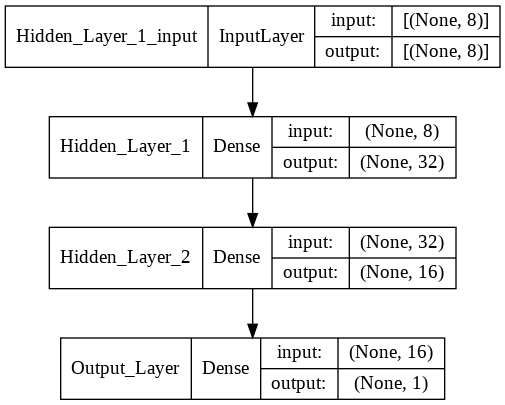

In [79]:
# Visualizing the model
keras.utils.plot_model(optimal_model, show_shapes=True)

In [80]:
# Training the model
n_epochs     = 500
n_batch_size = 100 

optimal_model_fitted = optimal_model.fit(
    X_train, 
    y_train, 
    epochs=n_epochs, 
    batch_size=n_batch_size, 
    validation_data=(X_test, y_test)
)

Epoch 1/500
163/163 [==============================] - 1s 3ms/step - loss: 0.5268 - mean_squared_error: 0.5268 - val_loss: 0.3492 - val_mean_squared_error: 0.3492
Epoch 2/500
163/163 [==============================] - 0s 2ms/step - loss: 0.3108 - mean_squared_error: 0.3108 - val_loss: 0.3061 - val_mean_squared_error: 0.3061
Epoch 3/500
163/163 [==============================] - 0s 2ms/step - loss: 0.2855 - mean_squared_error: 0.2855 - val_loss: 0.2910 - val_mean_squared_error: 0.2910
Epoch 4/500
163/163 [==============================] - 0s 2ms/step - loss: 0.2724 - mean_squared_error: 0.2724 - val_loss: 0.2804 - val_mean_squared_error: 0.2804
Epoch 5/500
163/163 [==============================] - 0s 2ms/step - loss: 0.2656 - mean_squared_error: 0.2656 - val_loss: 0.2761 - val_mean_squared_error: 0.2761
Epoch 6/500
163/163 [==============================] - 0s 3ms/step - loss: 0.2600 - mean_squared_error: 0.2600 - val_loss: 0.2720 - val_mean_squared_error: 0.2720
Epoch 7/500
163/163 [=

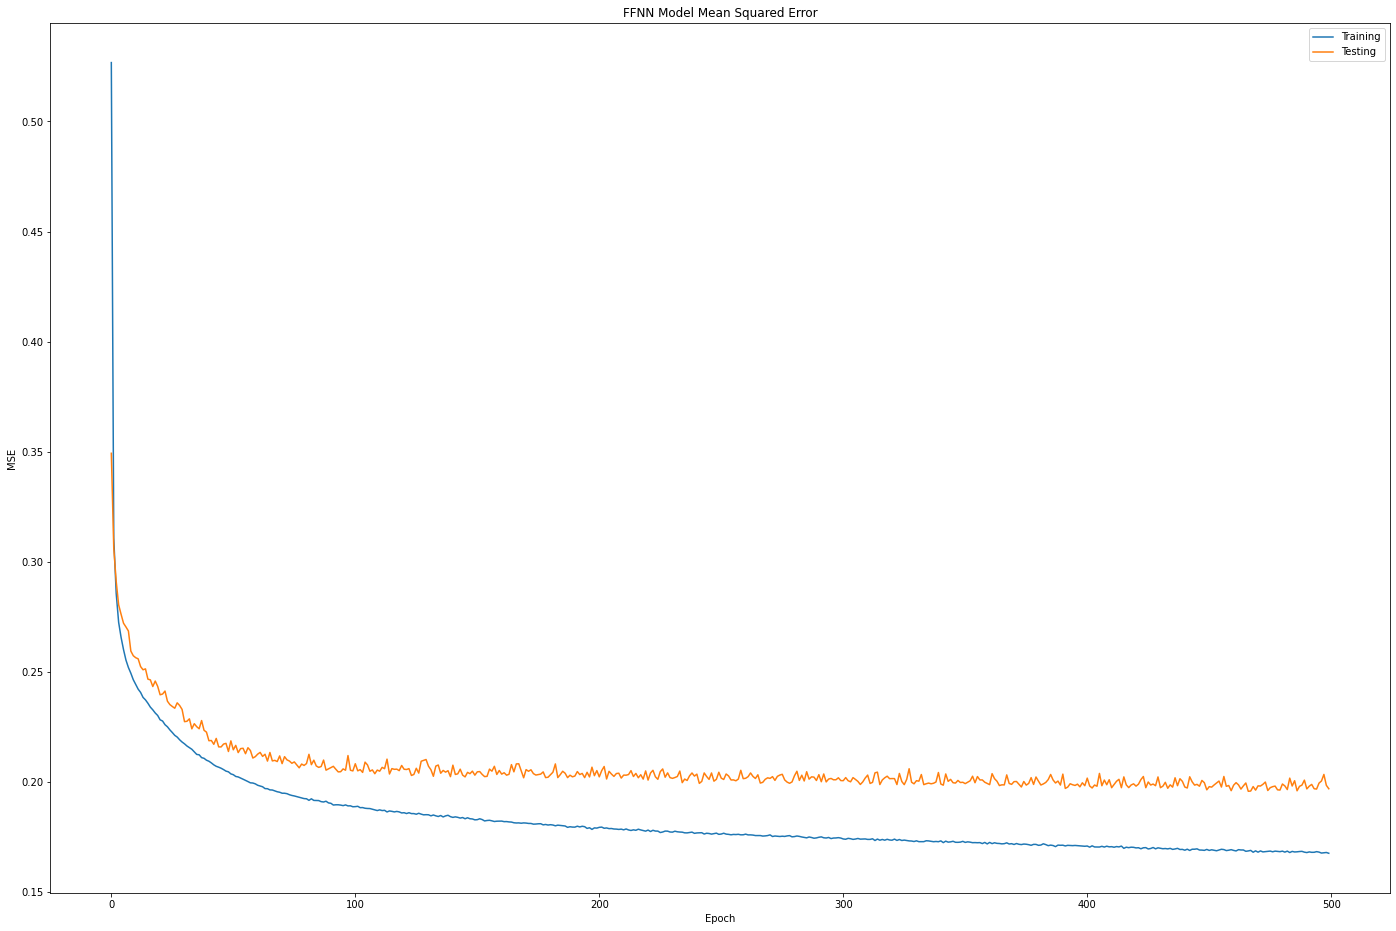

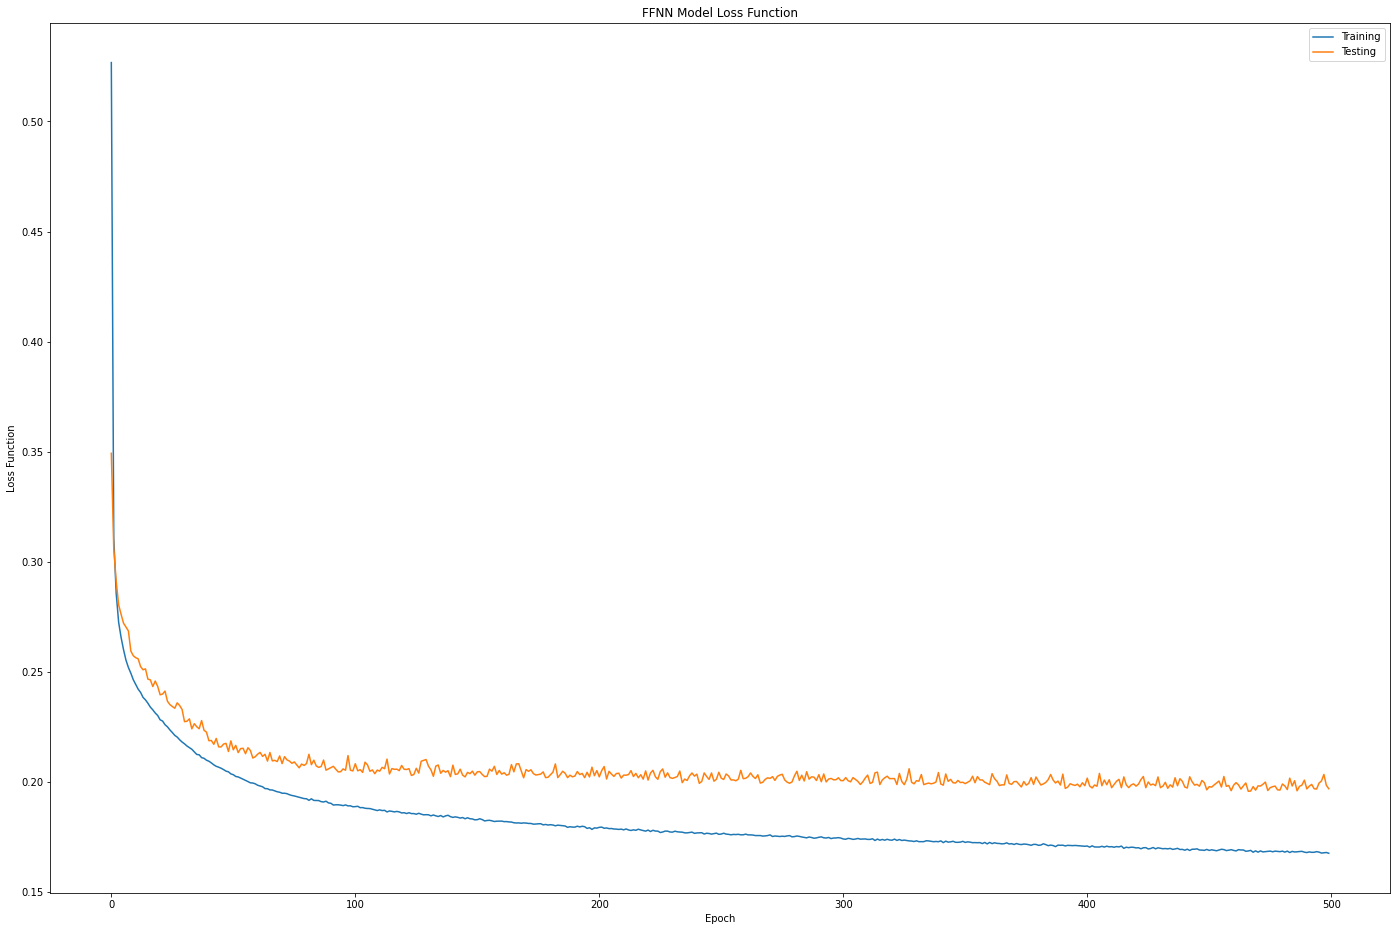

In [81]:
# Plot history for MSE
plt.figure(figsize=(24,16))
plt.plot(optimal_model_fitted.history['mean_squared_error'])
plt.plot(optimal_model_fitted.history['val_mean_squared_error'])
plt.title('FFNN Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

# Plot history for loss function
plt.figure(figsize=(24,16))
plt.plot(optimal_model_fitted.history['loss'])
plt.plot(optimal_model_fitted.history['val_loss'])
plt.title('FFNN Model Loss Function')
plt.ylabel('Loss Function')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], facecolor='white')
plt.show()

In [82]:
# Predicting the house prices

# Trainig set: in-sample prediction
y_pred_train = optimal_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
r_squared = r2_score(y_train, y_pred_train)

# Testing seg: out-of-sample prediction
y_pred_test = optimal_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)

In [83]:
# Saving model performance results
model_comparison.loc[3] = ['FFNN (2h, 32x16) - Tuned hyperparameters', r_squared, train_rmse, test_rmse]

## Model comparison

If we compare the new model, with tuned hyperparameters, we can see that it performed better across all the metrics:
- Highes R-squared score
- Lowest in-sample RMSE
- Lowest out-of-sample RMSE

And more importantly, we can see the improvements for this neural network achitecture (FFNN (2h, 32x16) ) when using different hyperparameters. Fine-tuning of our FFNN gave us a bit better model performace.

And as the previous FFNN models were already better than the regression models for this dataset, so is the new, tuned FFNN model.

In [84]:
model_comparison

,Model,R-squared (in-sample),RMSE (in-sample),RMSE (out-of-sample)
0,"FFNN (2h, 8x8)",0.793984,0.452650,0.464426
1,"FFNN (2h, 32x16)",0.811375,0.433123,0.468515
2,"FFNN (3h, 8x8x4)",0.769157,0.479149,0.490470
3,"FFNN (2h, 32x16) - Tuned hyperparameters",0.831474,0.409398,0.443674
